# Investigation of bump in data in nb of LC plot

In [193]:
import random
import uproot
import numpy as np
import pandas as pd
import hist
import mplhep as hep
import matplotlib.pyplot as plt
plt.style.use(hep.style.CMS)
import sys
sys.path.append("..")
from hists.dataframe import *
from hists.custom_hists import beamEnergiesAxis, cluster3D_size_axis

In [85]:
input_file_data = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v42/cmssw/data/CLUE_clusters.root'
input_file_sim = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v42/cmssw/sim_proton_v46_patchMIP/CLUE_clusters.root'
input_file_sim_noproton = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v38/cmssw/sim_noproton_v6/CLUE_clusters.root'
# for array_i in uproot.iterate(input_file + ":clusters", step_size="100MB", library="ak"):
#     series = array_i
#     break

In [233]:
uproot.open(input_file_data + ":clusters").arrays(filter_name=["beamEnergy", "ntupleNumber", "clus3D_*"], library="ak", cut="ntupleNumber != 453")

<Array [{beamEnergy: 300, ...}, ..., {...}] type='271000 * {beamEnergy: flo...'>

In [163]:
def makeSeries(input):
    s = uproot.open(input + ":clusters").arrays(filter_name=["beamEnergy", "ntupleNumber", "clus3D_*"], library="ak")
    return s, DataframeComputations(s)
series_data, comp_data = makeSeries(input_file_data)
series_sim, comp_sim = makeSeries(input_file_sim)
series_sim_noproton, comp_sim_noproton = makeSeries(input_file_sim_noproton)

In [209]:
ntuple_axis = hist.axis.IntCategory(np.unique(series_data.ntupleNumber), name="ntuple")
all_ntuples_100 = np.unique(series_data.ntupleNumber[series_data.beamEnergy==100])
matteo_ntuples_100 = [477, 479, 480, 481, 482, 484, 486, 487, 489, 490, 491] # from https://github.com/bonanomi/HGCALStandaloneAnalysis/blob/master/setup/config.py
no_matteo_ntuples = list(set(all_ntuples_100).difference(matteo_ntuples_100))
no_matteo_ntuples

[483]

In [225]:
all_ntuples_100

<Array [477, 479, 480, 481, 482, ..., 487, 489, 490, 491] type='12 * uint16'>

In [235]:
before = np.count_nonzero(np.isin(series_data.ntupleNumber, all_ntuples_100))
before

31248

In [236]:
after = np.count_nonzero(np.isin(series_data.ntupleNumber, matteo_ntuples_100))
after

28452

In [237]:
before-after

2796

In [239]:
(before-after)/after*100

9.827077182623366

In [165]:
comps = [comp_data, comp_sim, comp_sim_noproton]
legends = ["Data", "Sim (proton)", "Sim (noproton)"]

In [101]:
def normSimToData(h_list:list[hist.Hist]):
    h_list = list(h_list)
    data_count = h_list[0].sum()
    return [h_list[0]] + [h*data_count/h.sum() for h in h_list[1:]] 

In [109]:
def make_h_mainTrackster_smallLcCount(comp):
    h = hist.Hist( beamEnergiesAxis(), hist.axis.Regular(200, 0, 300, name="tracksterEnergy"))
    df = comp.clusters3D_largestCluster[comp.clusters3D_largestCluster.clus3D_size <20]
    h.fill(**{"tracksterEnergy":df.clus3D_energy, "beamEnergy": df.beamEnergy.to_numpy("int")})
    return h
h_mainTrackster_smallLcCount = [make_h_mainTrackster_smallLcCount(comp) for comp in comps]

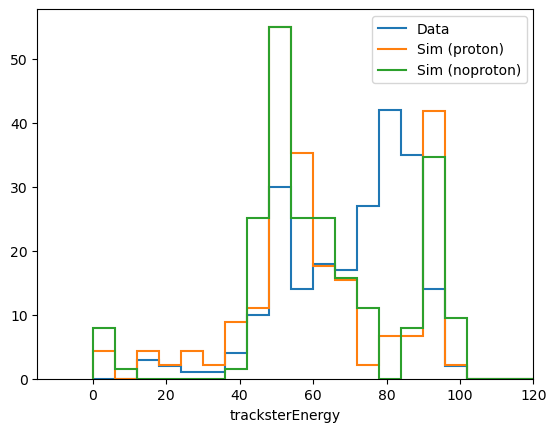

In [107]:

hep.histplot(normSimToData(map(lambda h:h[hist.loc(100), ::hist.rebin(4)], h_mainTrackster_smallLcCount)),
            yerr=False, label=legends)
plt.xlim(right=120)
plt.legend()

In [153]:
comp_data.clusters3D_largestCluster

,,beamEnergy,clus3D_x,clus3D_y,clus3D_z,clus3D_energy,clus3D_size
eventInternal,clus3D_id,,,,,,
0,0,300.0,3.161058,-2.023329,25.210642,288.672455,36
1,0,300.0,2.840648,-0.835566,27.068089,282.210052,34
2,0,300.0,2.259072,-1.402807,29.132622,281.997314,47
3,0,300.0,2.771630,-1.181302,25.748362,281.543182,38
4,0,300.0,2.382492,-0.543782,28.979586,287.227509,41
...,...,...,...,...,...,...,...
272850,0,200.0,2.020489,-0.898267,26.814400,194.366577,34
272851,0,200.0,1.990871,-1.783785,27.070732,193.092941,28
272852,0,200.0,3.208184,-2.016794,27.362741,199.715210,42


In [152]:
comp_data.array.ntupleNumber

<Array [435, 435, 435, 435, ..., 676, 676, 676, 676] type='272855 * uint16'>

In [169]:
def make_h_mainTrackster_energyProfileLCCount(comp):
    h = hist.Hist( beamEnergiesAxis(), ntuple_axis, cluster3D_size_axis(stop=30), storage="mean",)
    df = (ak.to_dataframe(comp.array[
            ["beamEnergy", "ntupleNumber", "clus3D_energy", "clus3D_size"]
            ], 
            levelname=lambda i : {0 : "eventInternal", 1:"clus3D_id"}[i])
        ).loc[comp.clusters3D_largestClusterIndex]
    h.fill(beamEnergy=df.beamEnergy.to_numpy("int"), ntuple=df.ntupleNumber.to_numpy("int"), clus3D_size=df.clus3D_size, sample=df.clus3D_energy)
    return h
h_mainTrackster_energyProfile = [make_h_mainTrackster_energyProfileLCCount(comp) for comp in comps]

Text(0.7, 0.1, '100 GeV')

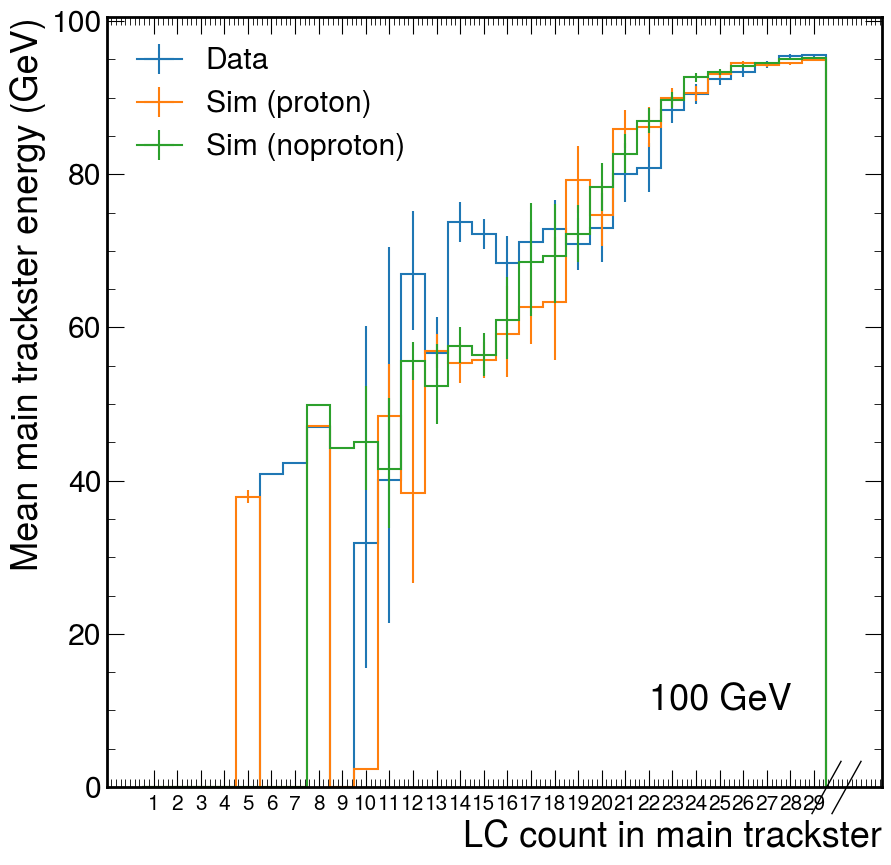

In [177]:
energy = 100
hep.histplot(list(map(lambda h:h[hist.loc(energy),::hist.sum,  :], h_mainTrackster_energyProfile)),
            yerr=True, label=legends)
#plt.xlim(right=120)
plt.ylabel("Mean main trackster energy (GeV)")
plt.xlabel("LC count in main trackster")
plt.tick_params(axis="x", labelsize=15)
plt.legend()
plt.text(0.7, 0.1, f"{energy} GeV", transform=plt.gca().transAxes)

/grid_mnt/data_cms_upgrade/cuisset/conda/envs/clustering-analysis/lib/python3.11/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Text(0.7, 0.1, '100 GeV\nreduced ntuples')

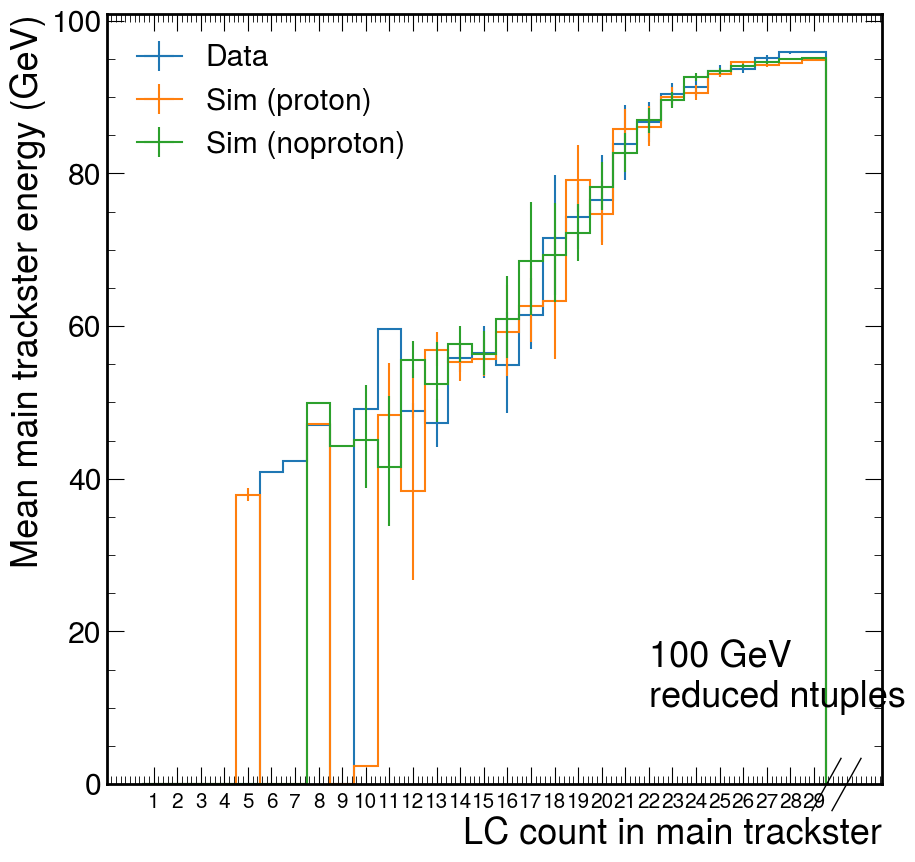

In [182]:
energy = 100
hep.histplot(list(map(lambda h:h[hist.loc(energy),list(map(hist.loc, matteo_ntuples_100)),  :].project("clus3D_size"), h_mainTrackster_energyProfile)),
            yerr=True, label=legends)
#plt.xlim(right=120)
plt.ylabel("Mean main trackster energy (GeV)")
plt.xlabel("LC count in main trackster")
plt.tick_params(axis="x", labelsize=15)
plt.legend()
plt.text(0.7, 0.1, f"{energy} GeV\nreduced ntuples", transform=plt.gca().transAxes)

/grid_mnt/data_cms_upgrade/cuisset/conda/envs/clustering-analysis/lib/python3.11/site-packages/hist/basehist.py:400: UserWarning: List indexing selection is experimental. Removed bins are not placed in overflow.
  return super().__getitem__(self._index_transform(index))


Text(0.7, 0.1, "100 GeV\nreduced ntuples excluding Matteo's")

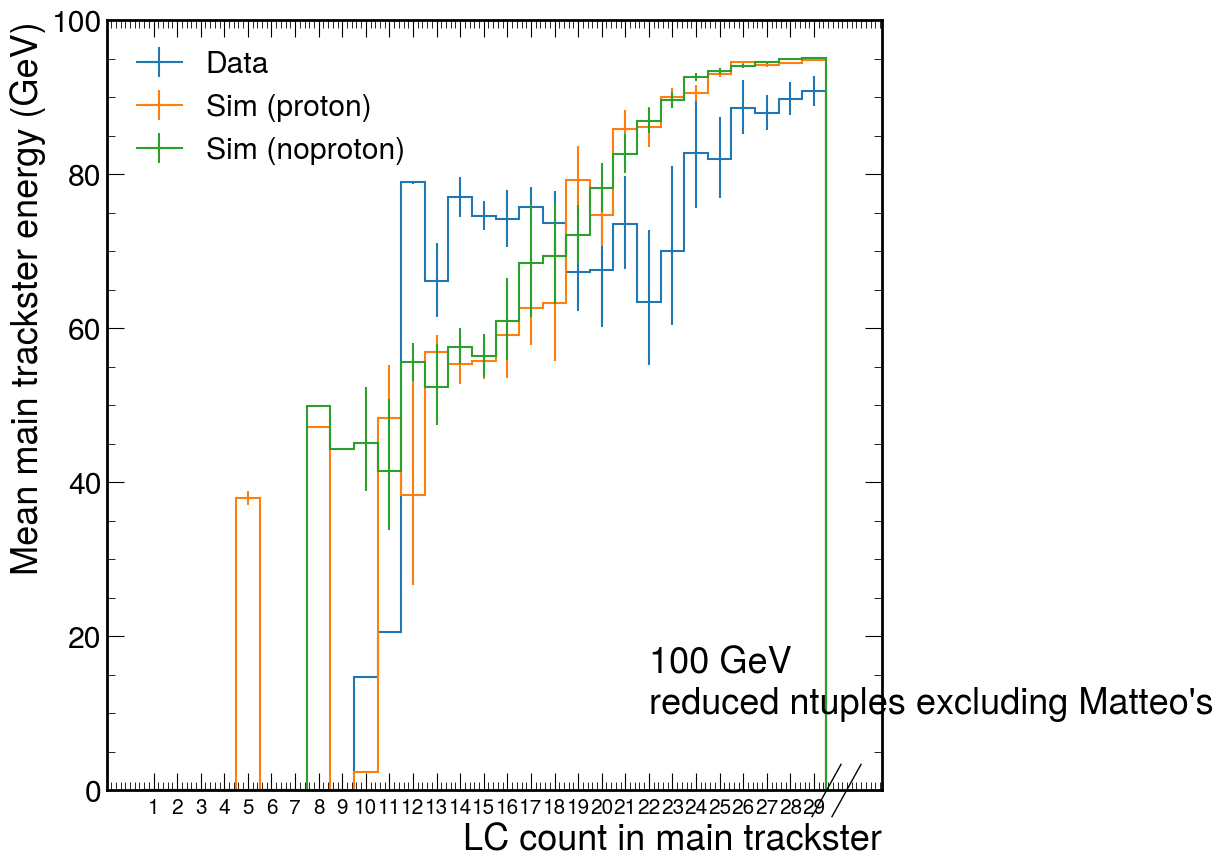

In [210]:
energy = 100
hep.histplot(list(map(lambda h:h[hist.loc(energy),list(map(hist.loc, no_matteo_ntuples)),  :].project("clus3D_size"), h_mainTrackster_energyProfile)),
            yerr=True, label=legends)
#plt.xlim(right=120)
plt.ylabel("Mean main trackster energy (GeV)")
plt.xlabel("LC count in main trackster")
plt.tick_params(axis="x", labelsize=15)
plt.legend()
plt.text(0.7, 0.1, f"{energy} GeV\nreduced ntuples excluding Matteo's", transform=plt.gca().transAxes)

Text(1, 0, 'Energy distribution (GeV)')

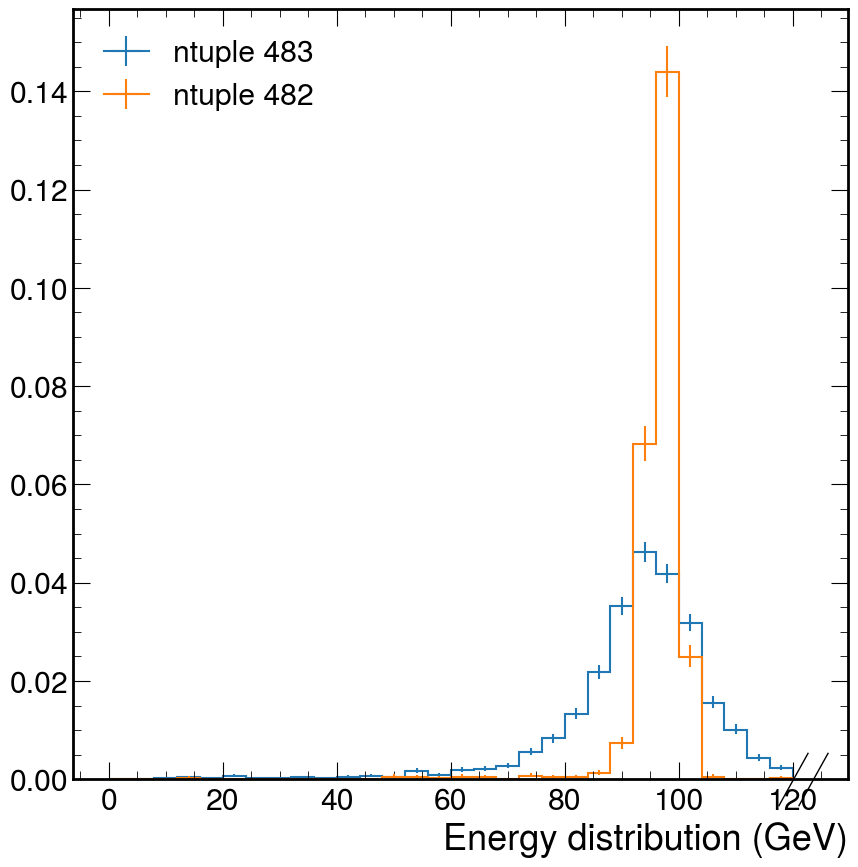

In [232]:
h = hist.Hist(hist.axis.Regular(30, 0, 120, name="energy"))
h.fill(ak.firsts(ak.sort(comp_data.array[comp_data.array.ntupleNumber == 483].clus3D_energy, ascending=False)))
h2 = hist.Hist(hist.axis.Regular(30, 0, 120, name="energy"))
h2.fill(ak.drop_none(ak.firsts(ak.sort(comp_data.array[(comp_data.array.ntupleNumber == 482) & (comp_data.array.beamEnergy==100)].clus3D_energy, ascending=False))))
hep.histplot([h, h2], density=True, label=["ntuple 483", "ntuple 482"])
plt.legend()
plt.xlabel("Energy distribution (GeV)")